In [1]:
import h5py
import os
import numpy as np

# Path to the preprocessed dataset
preprocessed_folder = r'C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/'

# Function to load cnt.mat and mrk.mat files
def process_eeg_data(folder):
    for file in os.listdir(folder):
        if file.endswith("_cnt.mat"):
            cnt_file = os.path.join(folder, file)
            mrk_file = cnt_file.replace("_cnt.mat", "_mrk.mat")
            
            if os.path.exists(mrk_file):
                print(f"Processing {cnt_file}...")
                
                with h5py.File(cnt_file, 'r') as f:
                    chunk_size = 50000
                    cnt_data = f['cnt']
                    for i in range(0, cnt_data.shape[0], chunk_size):
                        batch = cnt_data[i:i+chunk_size].astype(np.float32)
                        print(f"Processed batch {i // chunk_size + 1} of {cnt_data.shape[0] // chunk_size + 1}")
                
                with h5py.File(mrk_file, 'r') as f:
                    class_names = f['className'][:]
                    time_stamps = f['time'][:]
                    y_labels = f['y'][:]
                    print(f"Loaded marker data for {file}")

# Process EEG data file by file
process_eeg_data(preprocessed_folder)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/'

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Normalize EEG data
def normalize_data(data):
    return (data - np.mean(data)) / (np.std(data) + 1e-8)


def eeg_data_generator(folder, batch_size=32):
    for file in os.listdir(folder):
        if file.endswith("_cnt.mat"):
            cnt_file = os.path.join(folder, file)
            if os.path.exists(cnt_file):
                with h5py.File(cnt_file, 'r') as f:
                    cnt_data = f['cnt']
                    chunk_size = 50000 
                    
                    for i in range(0, cnt_data.shape[0], chunk_size):
                        batch = cnt_data[i:i+chunk_size].astype(np.float32)
                        batch = normalize_data(batch)
                        
                        for j in range(0, batch.shape[0], batch_size):
                            yield batch[j:j+batch_size]

# VAE Parameters
input_shape = (63,) 
latent_dim = 8

def build_vae(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape, name="encoder_input")
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * K.clip(z_log_var, -10, 10)) * epsilon
    
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    
    decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(128, activation="relu")(decoder_input)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    reconstructed_output = layers.Dense(input_shape[0], activation="linear")(x)
    
    decoder = models.Model(decoder_input, reconstructed_output, name="decoder")
    reconstructed = decoder(z)
    
    class VAE_LossLayer(layers.Layer):
        def call(self, inputs):
            inputs, reconstructed, z_mean, z_log_var = inputs
            reconstruction_loss = K.mean(K.square(inputs - reconstructed))
            kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(K.clip(z_log_var, -10, 10)))
            self.add_loss(reconstruction_loss + kl_loss)
            return reconstructed
    
    outputs = VAE_LossLayer()([inputs, reconstructed, z_mean, z_log_var])
    vae = models.Model(inputs, outputs, name="vae")
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
    encoder = models.Model(inputs, z_mean, name="encoder")
    
    return vae, encoder, decoder

# Build VAE
vae, encoder, decoder = build_vae(input_shape, latent_dim)
vae.summary()


dataset = tf.data.Dataset.from_generator(
    lambda: eeg_data_generator(preprocessed_folder, batch_size=32),
    output_signature=tf.TensorSpec(shape=(None, input_shape[0]), dtype=tf.float32)
).prefetch(tf.data.experimental.AUTOTUNE)

# Train the VAE
vae.fit(dataset, epochs=10, steps_per_epoch=1000)

# Generate latent representations for a batch of EEG data
for batch in dataset.take(1):
    latent_representations = encoder.predict(batch)
    print("Latent Representation Sample:", latent_representations[:5])

# Generate synthetic EEG samples
latent_space_samples = np.random.normal(size=(10, latent_dim))
augmented_eeg = decoder.predict(latent_space_samples)
print("Augmented EEG Data Shape:", augmented_eeg.shape)


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 63)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │      8,192 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      8,256 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │        520 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │        520 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 8)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 63)        │     75,199 │ z[0][0]           │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae__loss_layer_3   │ (None, 63)        │          0 │ encoder_input[0]… │
│ (VAE_LossLayer)     │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,687 (362.06 KB)

 Trainable params: 92,687 (362.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1302
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0019
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.3330e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.7397e-04
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.2176e-04
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.2213e-04
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7713e-04
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.6709e-04
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.6807e-04
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.6195e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Latent Representation Sample: [[ 0.01062441 -0.02198532 -0.0027208  -0.00686425  0.01184812 -0.00683268
   0.00542761 -0.01781897]
 [ 0.01067909 -0.02197663 -0.00276884 -0.00686982  0.01182541 -0.00677397
   0.0055857  -0.01780179]
 [ 0.01

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Augmented EEG Data Shape: (10, 63)
Latent Representation Shape: (32, 8)


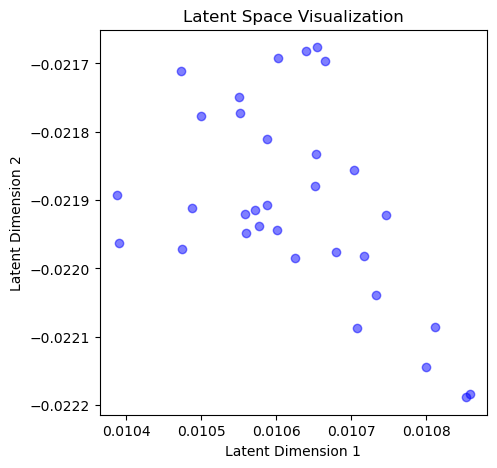

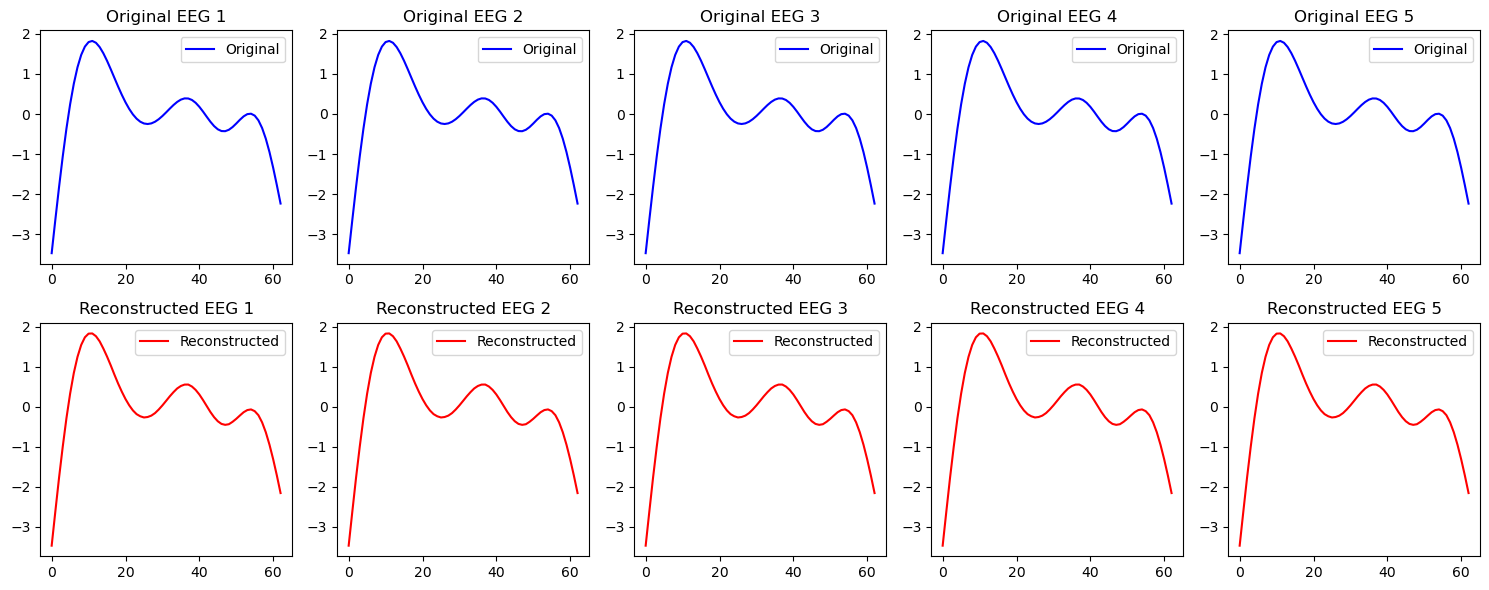

In [17]:
import matplotlib.pyplot as plt

# Generate Augmented EEG Data
latent_space_samples = np.random.normal(size=(10, latent_dim))
augmented_eeg = decoder.predict(latent_space_samples)

for batch in dataset.take(1):
    sample_eeg_batch = batch.numpy()
    latent_representations = encoder.predict(sample_eeg_batch)
    reconstructed_eeg = decoder.predict(latent_representations)

print("Augmented EEG Data Shape:", augmented_eeg.shape)
print("Latent Representation Shape:", latent_representations.shape)

# Latent Space Scatter Plot
plt.figure(figsize=(5, 5))
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], alpha=0.5, color='blue')
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization")
plt.show()

# Original vs. Reconstructed EEG Signals
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axes[0, i].plot(sample_eeg_batch[i], color='blue')
    axes[0, i].set_title(f"Original EEG {i+1}")
    axes[0, i].legend(["Original"])

    axes[1, i].plot(reconstructed_eeg[i], color='red')
    axes[1, i].set_title(f"Reconstructed EEG {i+1}")
    axes[1, i].legend(["Reconstructed"])

plt.tight_layout()
plt.show()


Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub10_cnt.mat...
Loaded first chunk of Sub10_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step


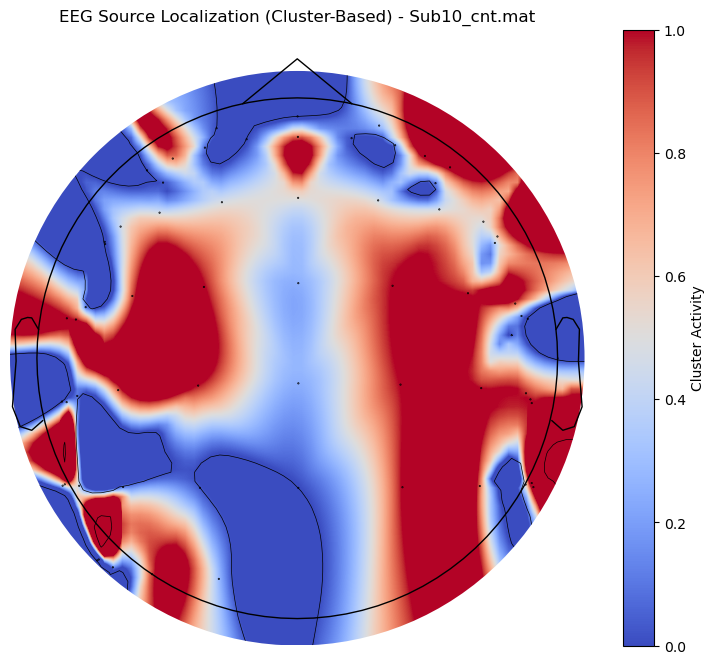

Finished processing first chunk of Sub10_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub11_cnt.mat...
Loaded first chunk of Sub11_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step


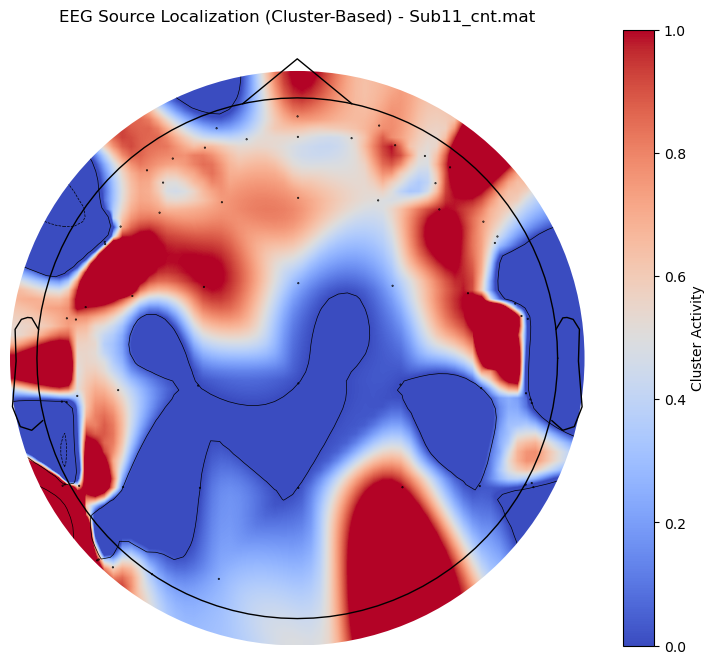

Finished processing first chunk of Sub11_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub13_cnt.mat...
Loaded first chunk of Sub13_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step


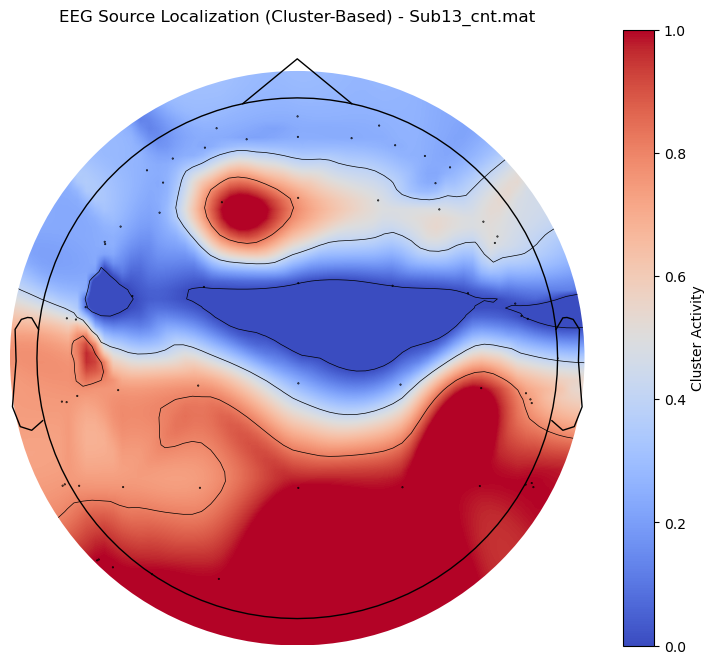

Finished processing first chunk of Sub13_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub14_cnt.mat...
Loaded first chunk of Sub14_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step


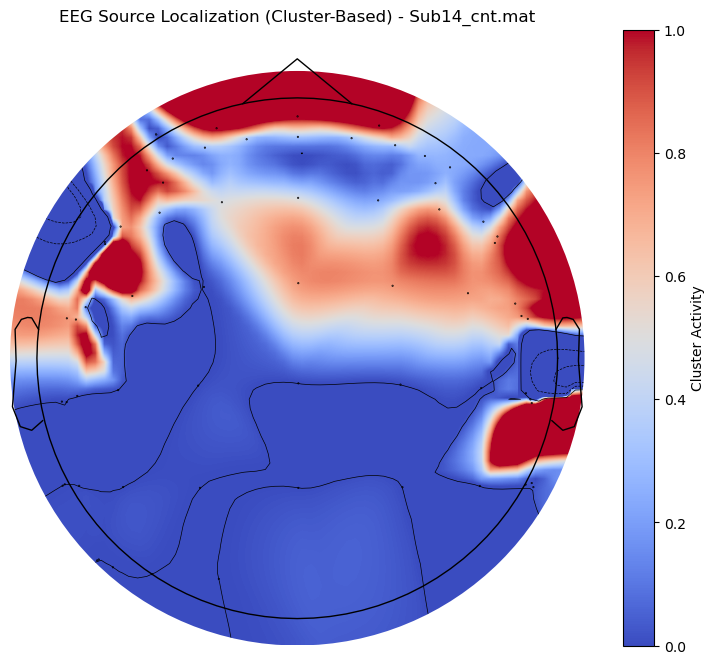

Finished processing first chunk of Sub14_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub15_cnt.mat...
Loaded first chunk of Sub15_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step


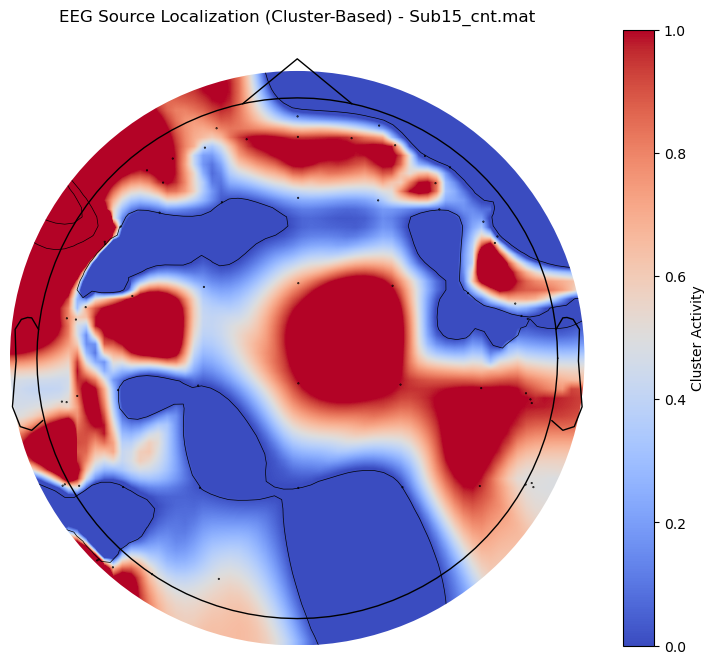

Finished processing first chunk of Sub15_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub16_cnt.mat...
Loaded first chunk of Sub16_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step


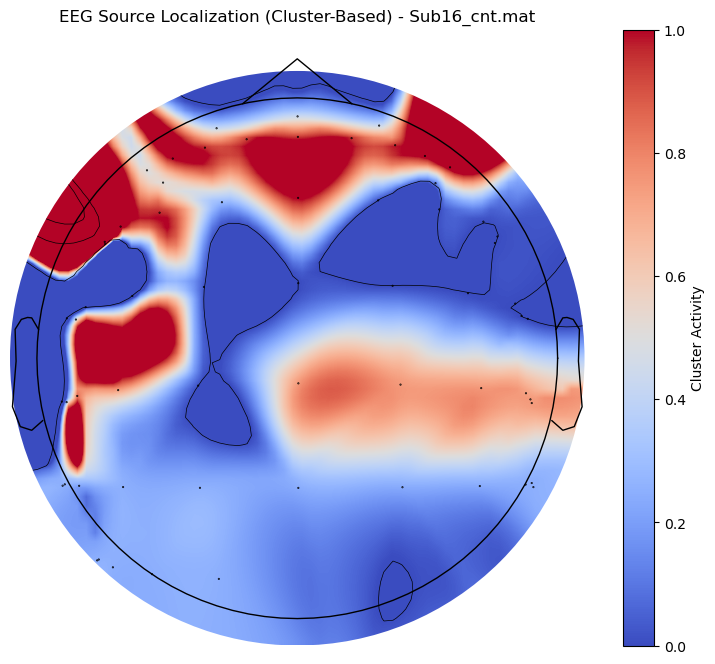

Finished processing first chunk of Sub16_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub17_cnt.mat...
Loaded first chunk of Sub17_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step


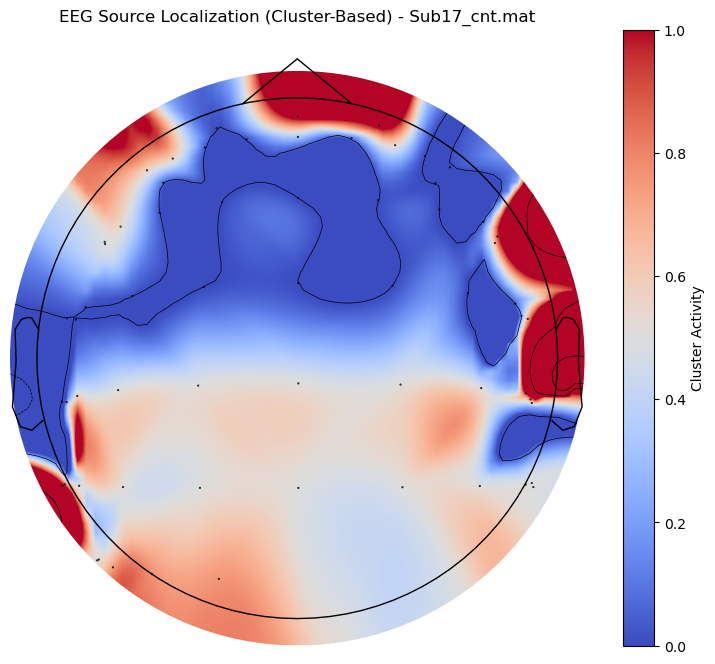

Finished processing first chunk of Sub17_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub18_cnt.mat...
Loaded first chunk of Sub18_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step


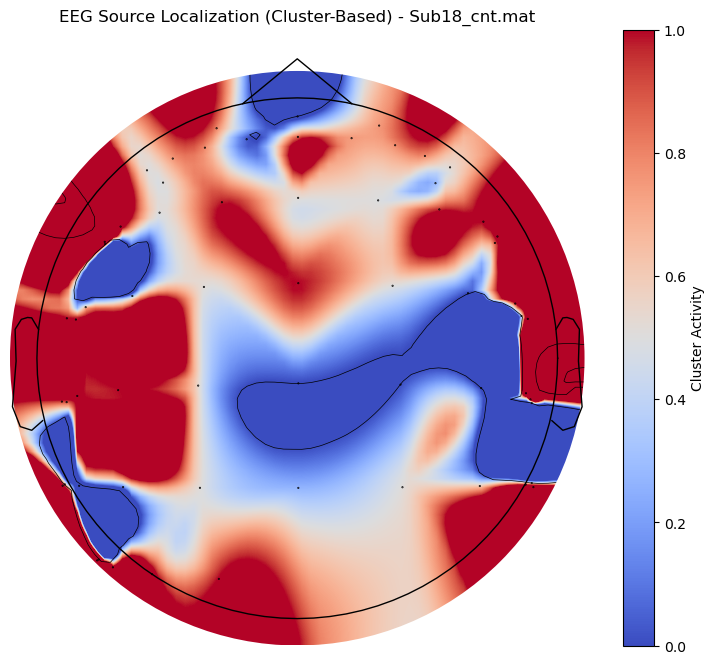

Finished processing first chunk of Sub18_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub19_cnt.mat...
Loaded first chunk of Sub19_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step


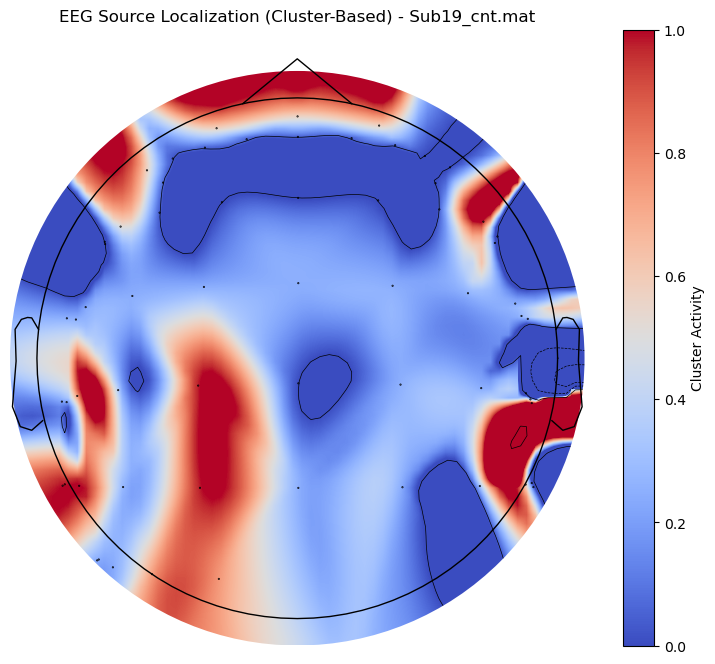

Finished processing first chunk of Sub19_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub20_cnt.mat...
Loaded first chunk of Sub20_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step


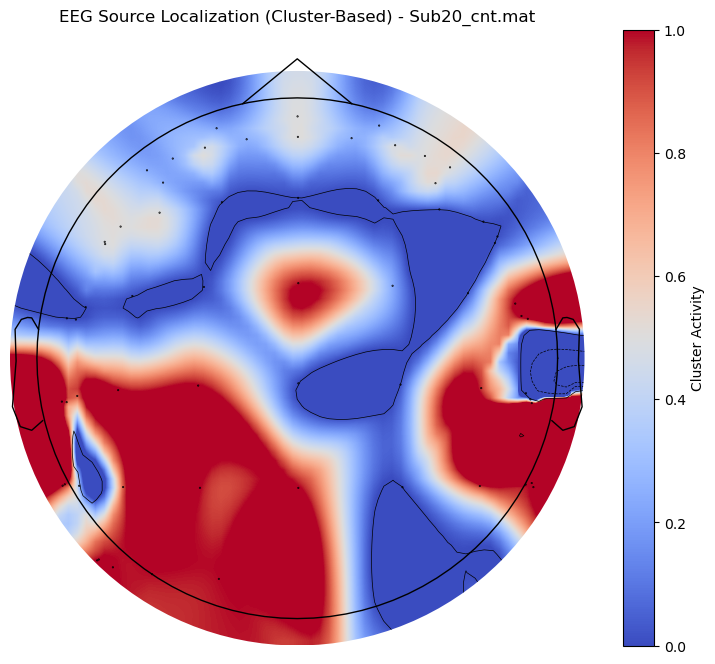

Finished processing first chunk of Sub20_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub21_cnt.mat...
Loaded first chunk of Sub21_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step


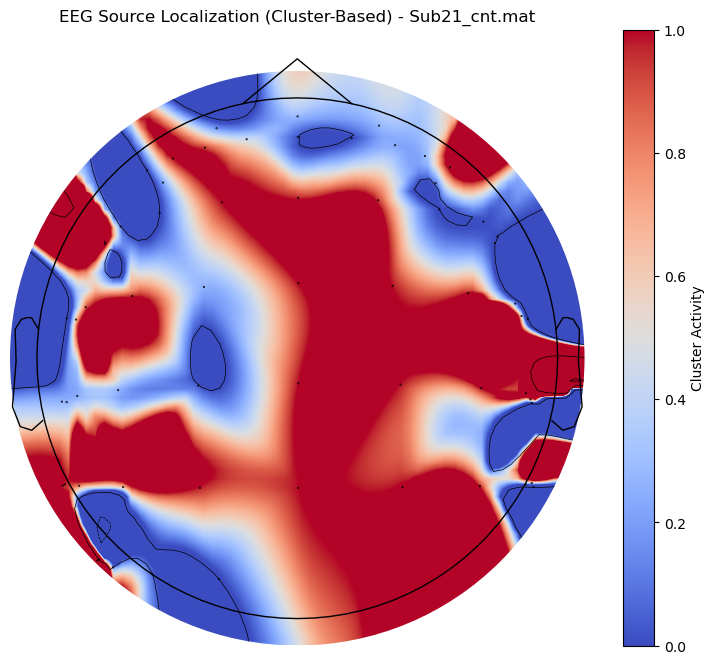

Finished processing first chunk of Sub21_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub22_cnt.mat...
Loaded first chunk of Sub22_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step


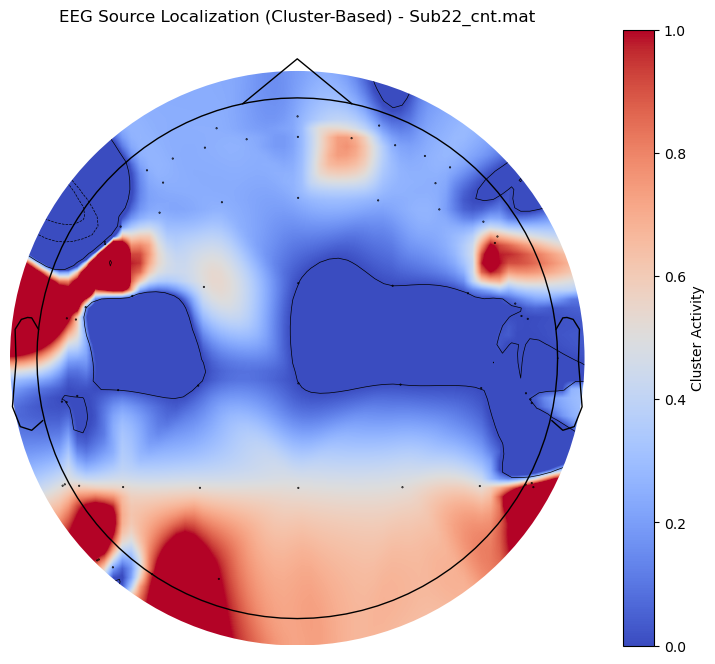

Finished processing first chunk of Sub22_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub23_cnt.mat...
Loaded first chunk of Sub23_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step


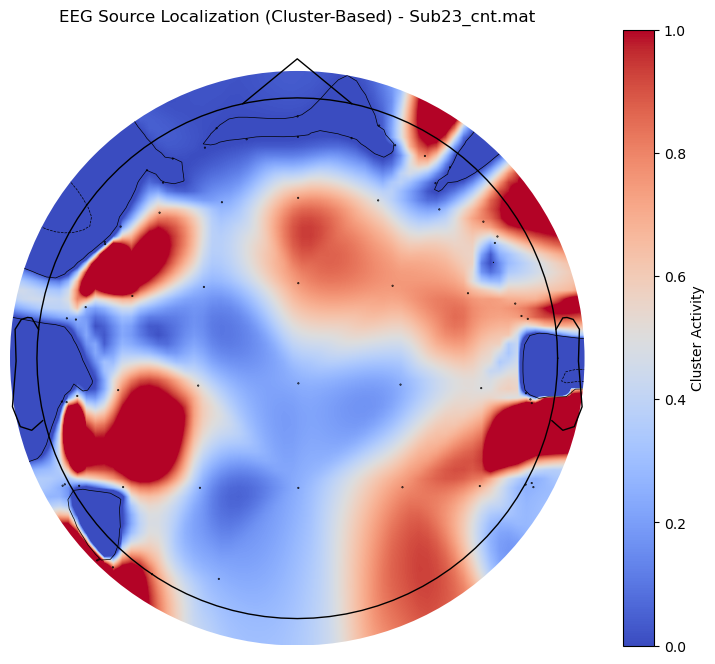

Finished processing first chunk of Sub23_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub24_cnt.mat...
Loaded first chunk of Sub24_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step


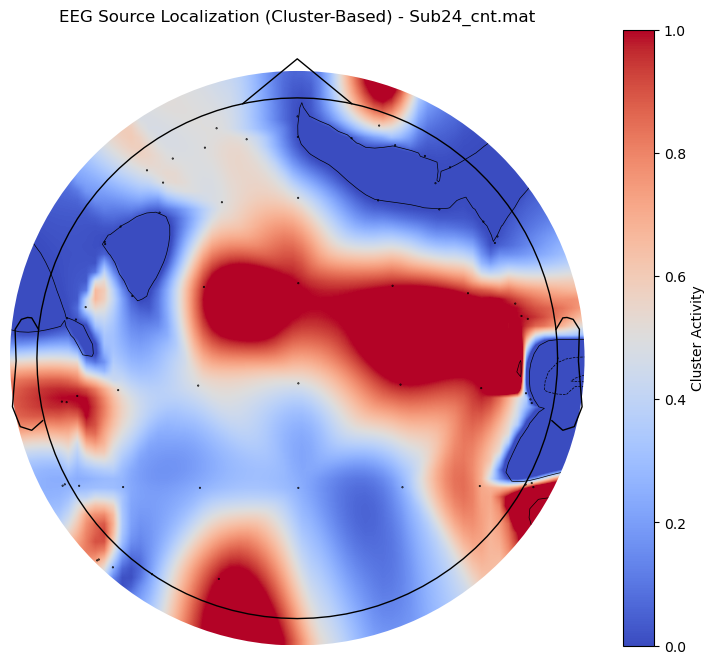

Finished processing first chunk of Sub24_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub26_cnt.mat...
Loaded first chunk of Sub26_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step


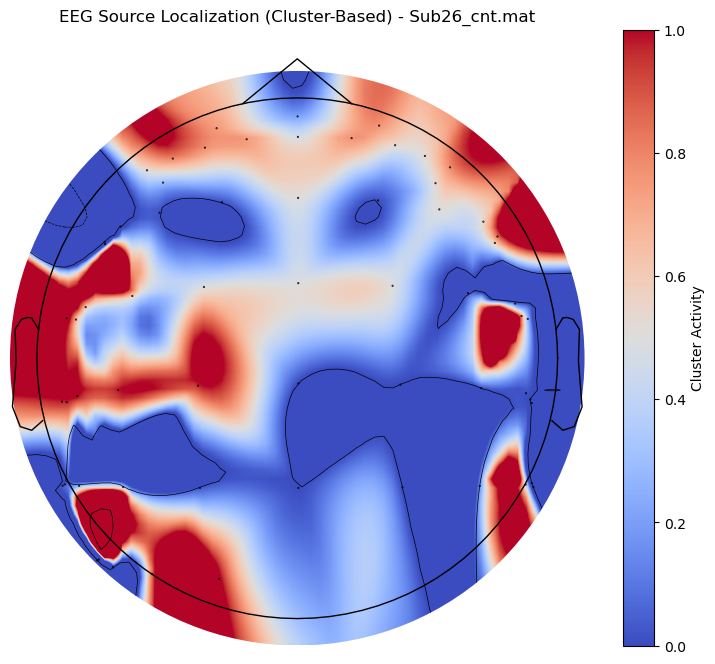

Finished processing first chunk of Sub26_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub28_cnt.mat...
Loaded first chunk of Sub28_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step


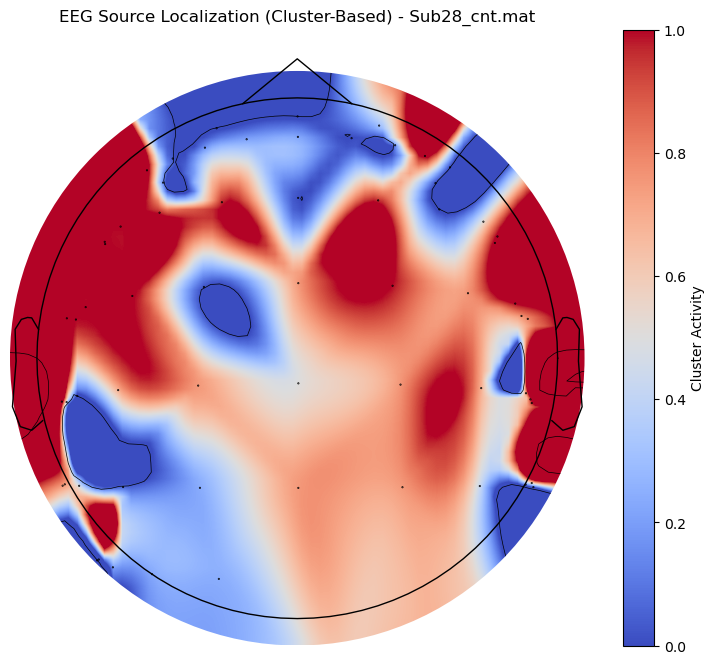

Finished processing first chunk of Sub28_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub29_cnt.mat...
Loaded first chunk of Sub29_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step


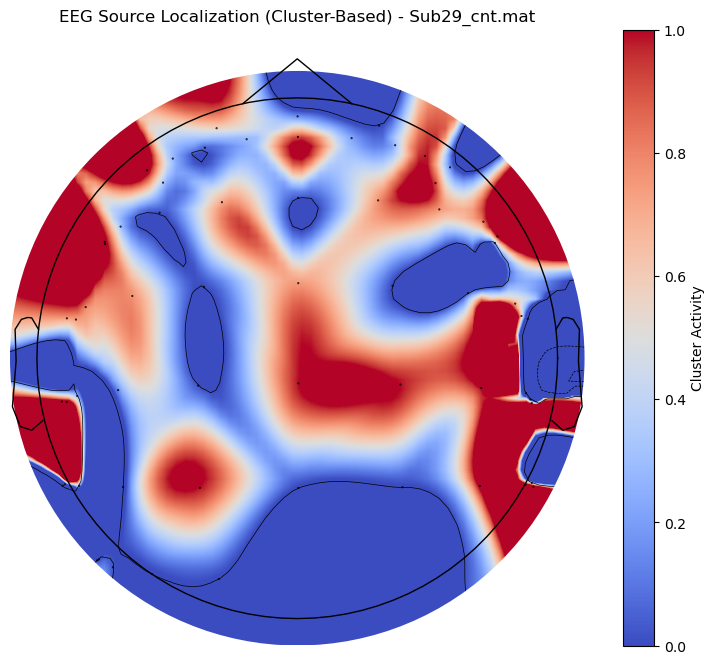

Finished processing first chunk of Sub29_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub2_cnt.mat...
Loaded first chunk of Sub2_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step


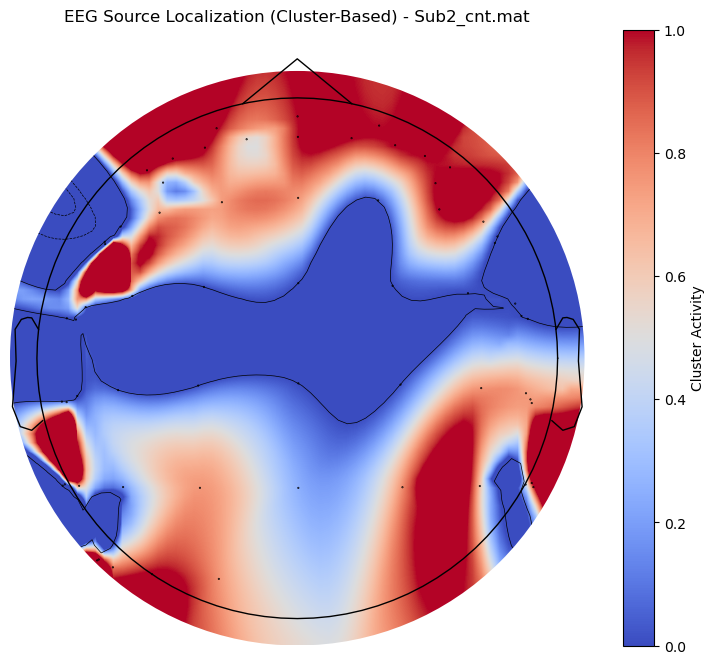

Finished processing first chunk of Sub2_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub30_cnt.mat...
Loaded first chunk of Sub30_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step


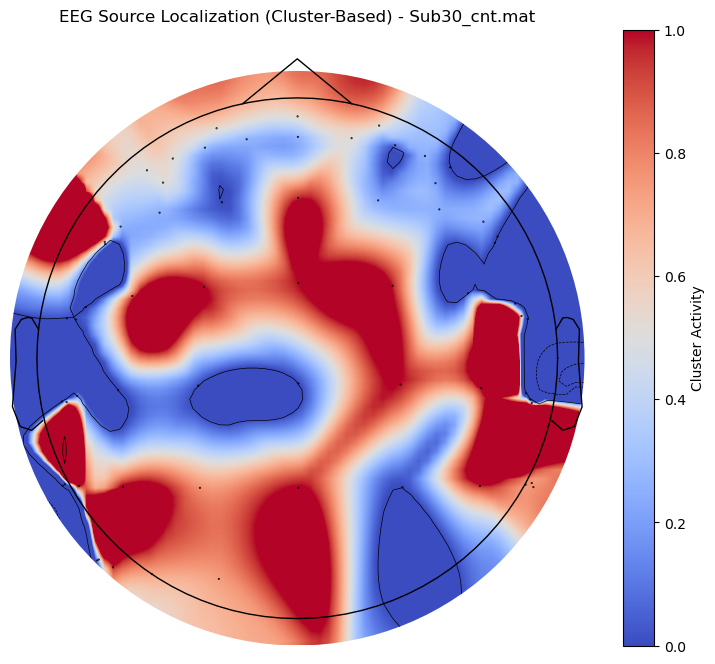

Finished processing first chunk of Sub30_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub31_cnt.mat...
Loaded first chunk of Sub31_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step


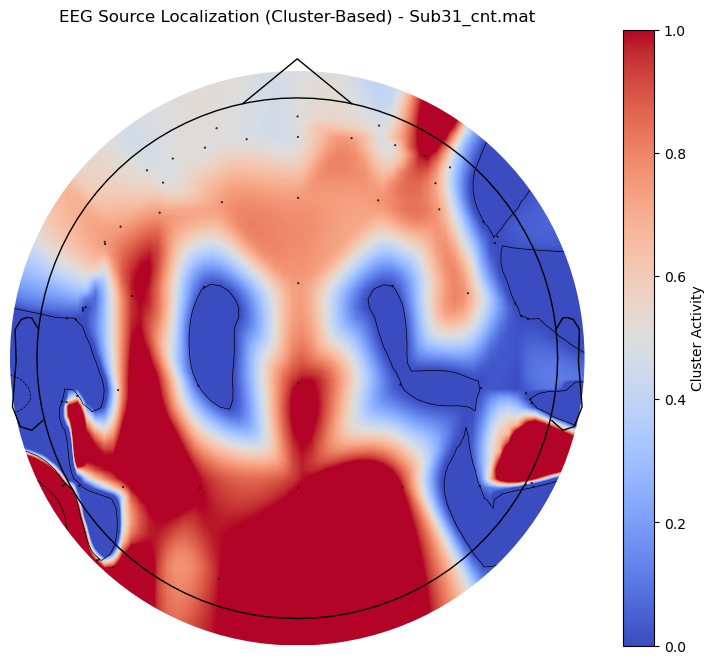

Finished processing first chunk of Sub31_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub32_cnt.mat...
Loaded first chunk of Sub32_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step


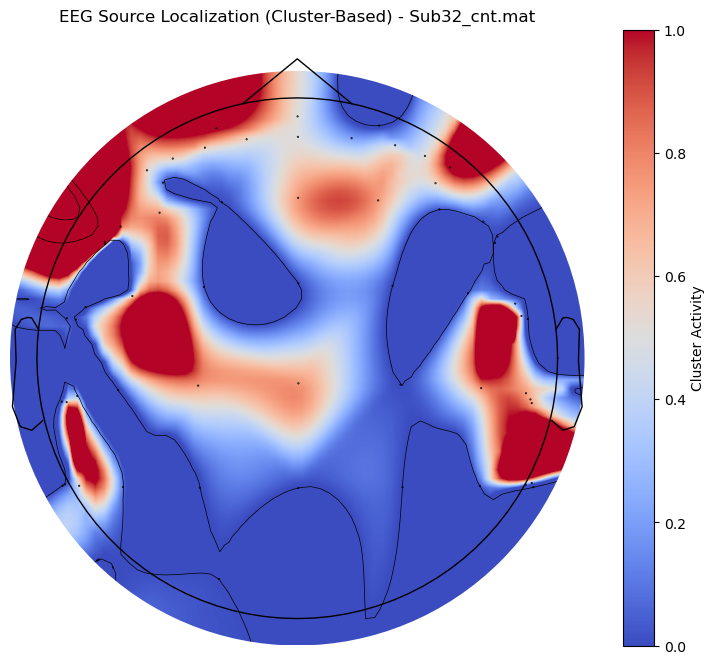

Finished processing first chunk of Sub32_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub33_cnt.mat...
Loaded first chunk of Sub33_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step


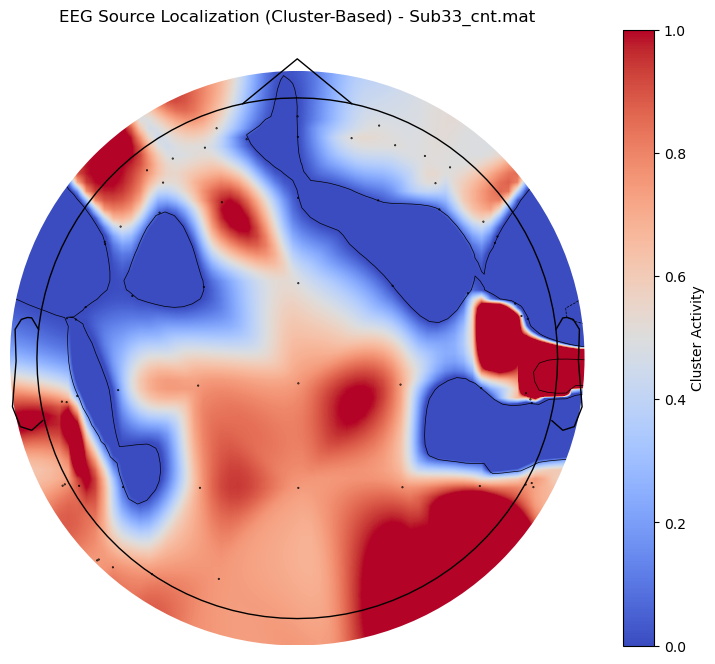

Finished processing first chunk of Sub33_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub35_cnt.mat...
Loaded first chunk of Sub35_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step


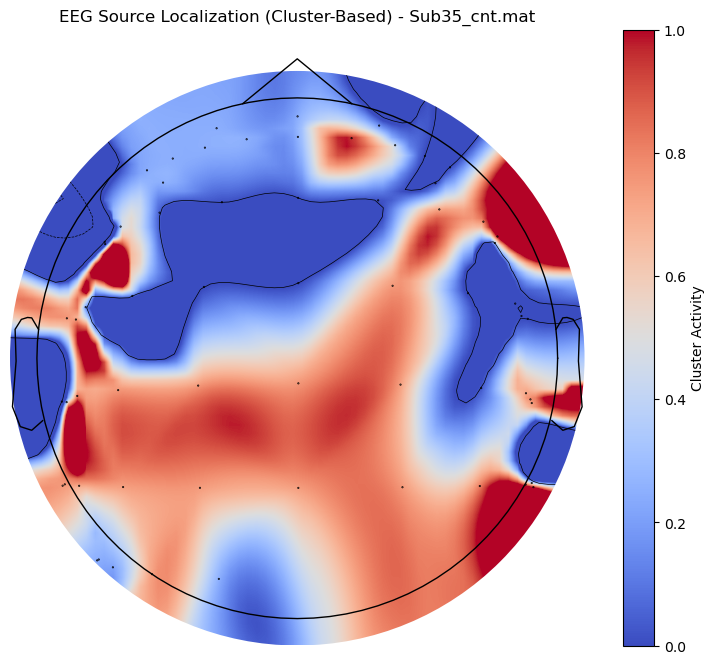

Finished processing first chunk of Sub35_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub37_cnt.mat...
Loaded first chunk of Sub37_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step


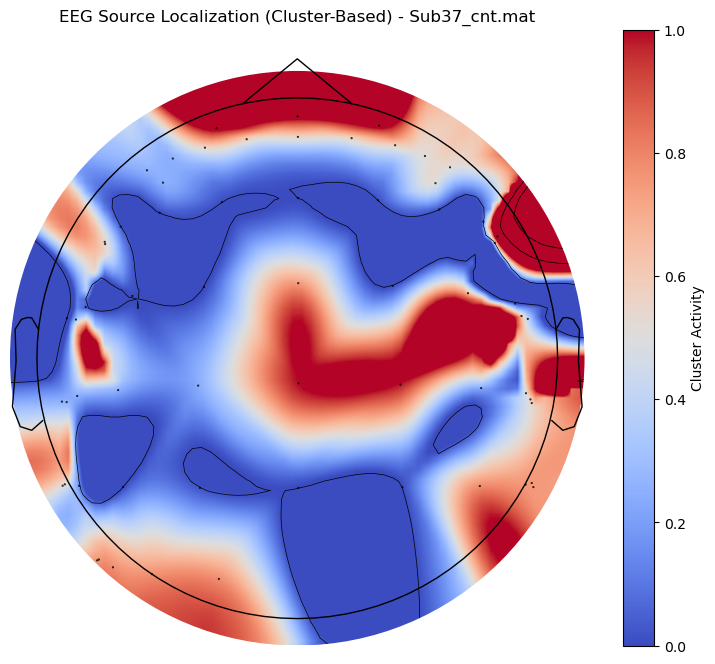

Finished processing first chunk of Sub37_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub39_cnt.mat...
Loaded first chunk of Sub39_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step


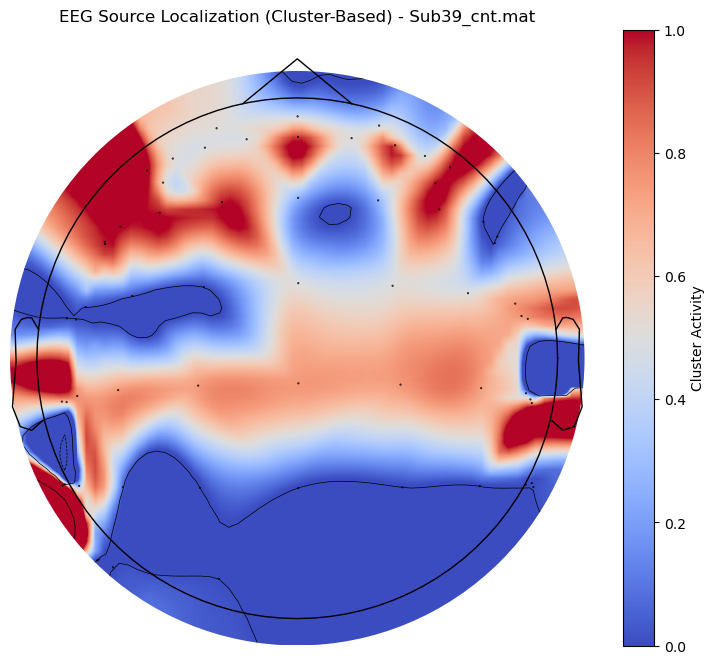

Finished processing first chunk of Sub39_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub3_cnt.mat...
Loaded first chunk of Sub3_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step


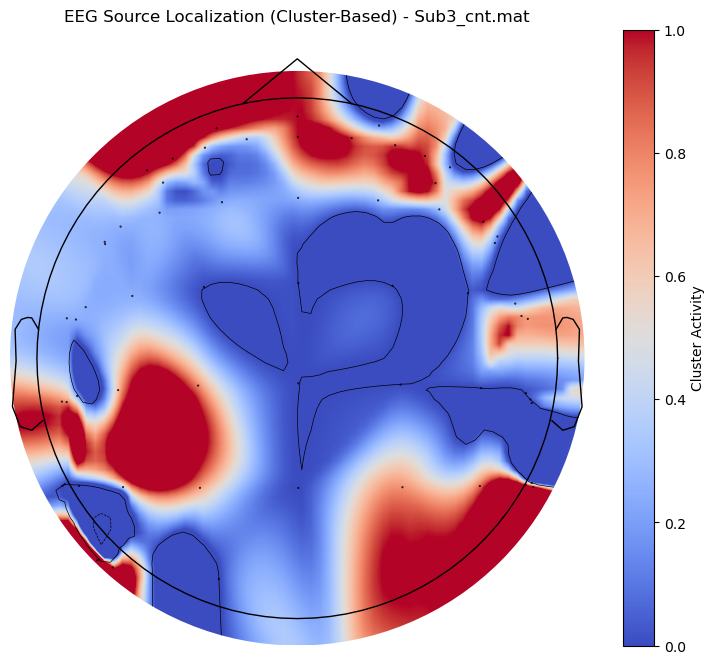

Finished processing first chunk of Sub3_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub40_cnt.mat...
Loaded first chunk of Sub40_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step


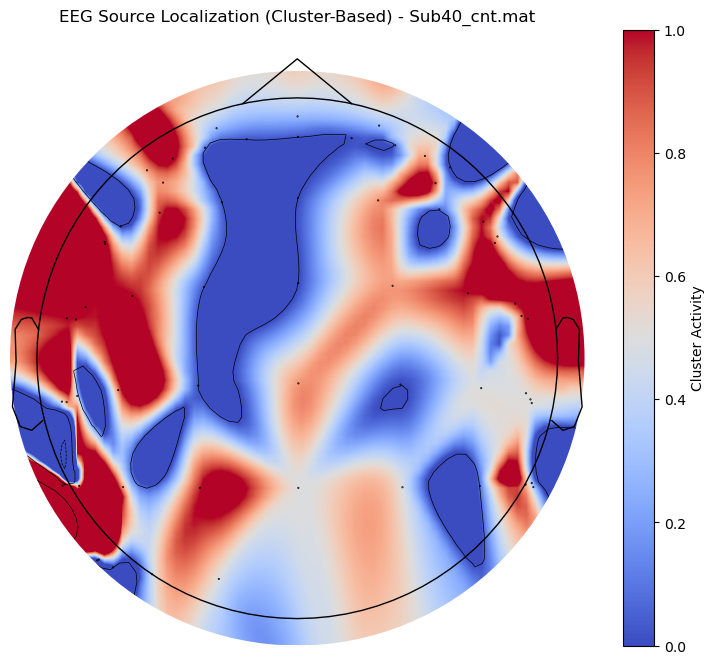

Finished processing first chunk of Sub40_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub41_cnt.mat...
Loaded first chunk of Sub41_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step


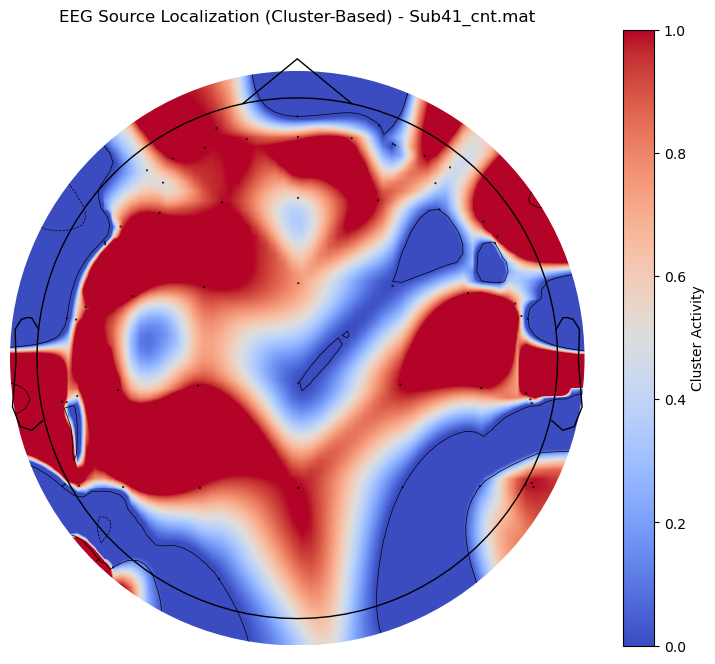

Finished processing first chunk of Sub41_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub42_cnt.mat...
Loaded first chunk of Sub42_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step


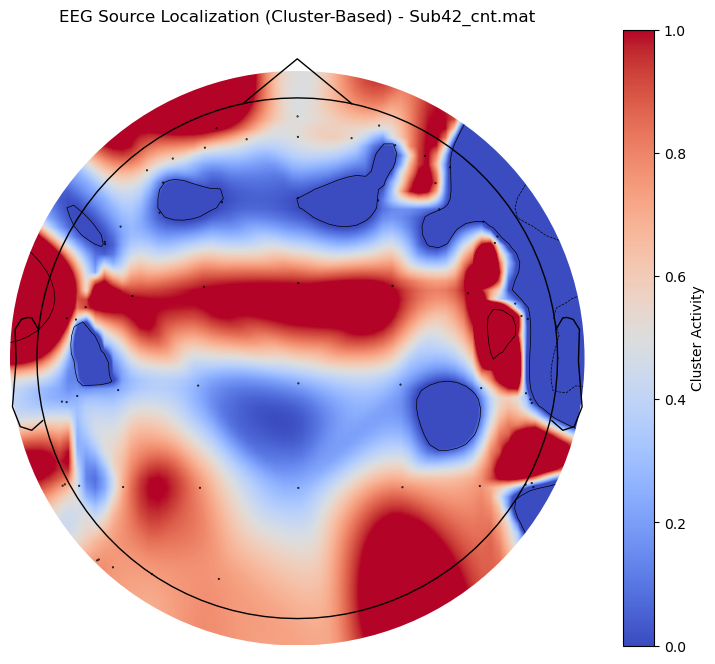

Finished processing first chunk of Sub42_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub44_cnt.mat...
Loaded first chunk of Sub44_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step


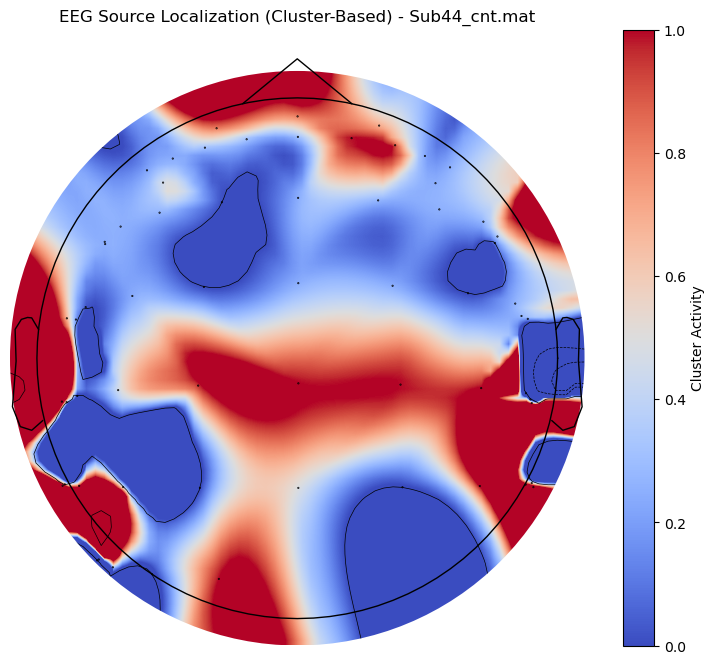

Finished processing first chunk of Sub44_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub5_cnt.mat...
Loaded first chunk of Sub5_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step


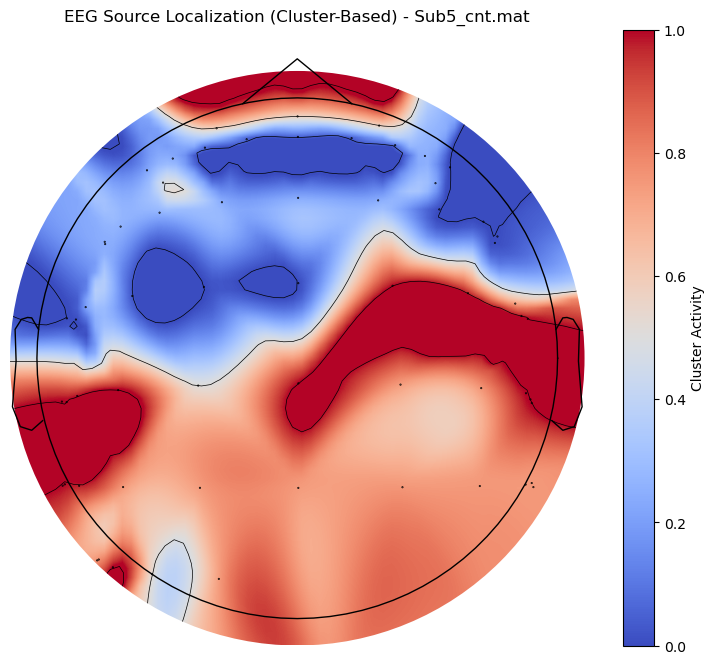

Finished processing first chunk of Sub5_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub7_cnt.mat...
Loaded first chunk of Sub7_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step


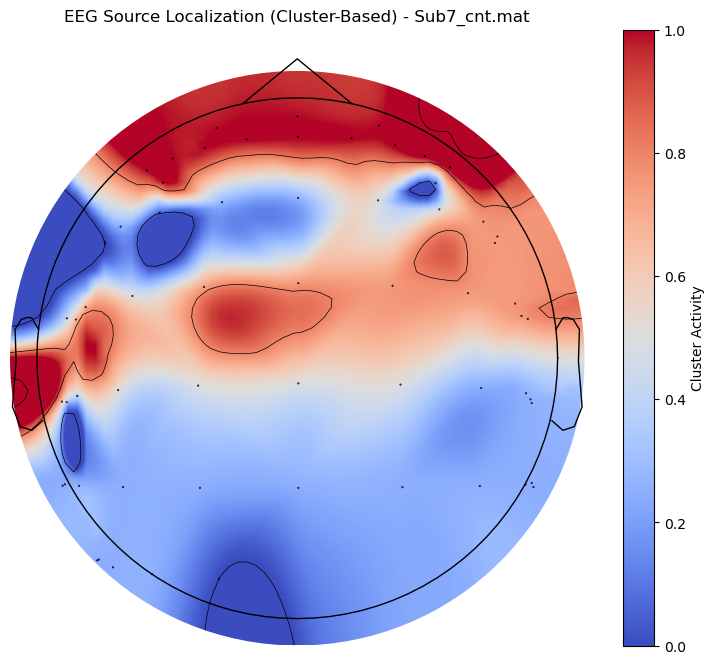

Finished processing first chunk of Sub7_cnt.mat

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset/Sub8_cnt.mat...
Loaded first chunk of Sub8_cnt.mat: 50000 samples, 63 channels.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step


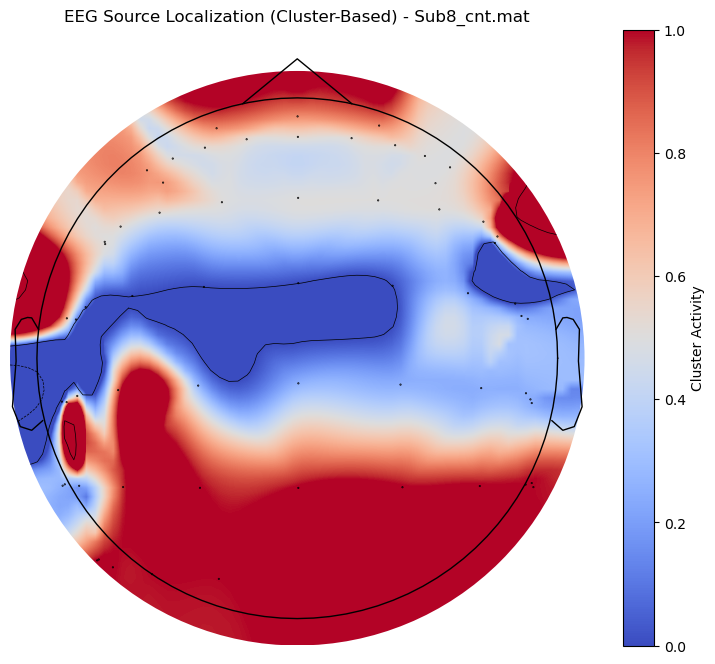

Finished processing first chunk of Sub8_cnt.mat



In [27]:
import mne
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors


os.environ["OMP_NUM_THREADS"] = "4"

# Function to load EEG data
def load_cnt_data_in_chunks(file_path, chunk_size=50000):
    with h5py.File(file_path, 'r') as f:
        cnt_data = f['cnt']
        total_samples = cnt_data.shape[0]
        
        for start in range(0, total_samples, chunk_size):
            end = min(start + chunk_size, total_samples)
            yield cnt_data[start:end, :]  # Yield one chunk at a time

# Function to process EEG files
def process_eeg_data(folder):
    for file in os.listdir(folder):
        if file.endswith("_cnt.mat"):
            cnt_file = os.path.join(folder, file)
            mrk_file = cnt_file.replace("_cnt.mat", "_mrk.mat")
            
            if os.path.exists(mrk_file):
                print(f"Processing {cnt_file}...")

                first_chunk = next(load_cnt_data_in_chunks(cnt_file))
                num_samples, num_channels = first_chunk.shape
                print(f"Loaded first chunk of {file}: {num_samples} samples, {num_channels} channels.")

                # Apply VAE for Feature Extraction
                latent_representations = encoder.predict(first_chunk)

                # K-Means Clustering in Latent Space
                num_clusters = 5
                kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
                kmeans_labels = kmeans.fit_predict(latent_representations)

                # Visualize Latent Space Clusters
                if latent_representations.shape[1] == 2:
                    plt.figure(figsize=(8, 6))
                    plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
                    plt.colorbar(label='Cluster ID')
                    plt.xlabel("Latent Dimension 1")
                    plt.ylabel("Latent Dimension 2")
                    plt.title(f"Latent Space Clustering - {file}")
                    plt.grid(True)
                    plt.show()

                # Prepare for EEG Source Localization
                montage = mne.channels.make_standard_montage("standard_1020")
                info = mne.create_info(ch_names=montage.ch_names[:num_channels], sfreq=250, ch_types=['eeg'] * num_channels)
                info.set_montage(montage, match_case=False)

                # Extract 2D Electrode Positions
                ch_positions = montage.get_positions()['ch_pos']
                pos = np.array([ch_positions[ch][:2] for ch in info.ch_names])

                # Assign Cluster Activity to Channels
                activity = np.zeros(num_channels, dtype=np.float64)

                # Map clusters to channels based on mean cluster
                cluster_indices = np.linspace(0, num_samples - 1, num_channels, dtype=int)
                for i, ch_idx in enumerate(cluster_indices):
                    activity[i] = kmeans_labels[ch_idx]

                # Normalize activity values
                if activity.max() > activity.min():
                    activity = (activity - activity.min()) / (activity.max() - activity.min())
                else:
                    activity = np.zeros(num_channels)

                if np.std(activity) < 0.1:
                    activity = (activity - activity.mean()) / (np.std(activity) + 1e-6)
                    activity = (activity - activity.min()) / (activity.max() - activity.min())

                activity = np.array(activity, dtype=np.float64).flatten()

                # Plot EEG Source Localization
                fig, ax = plt.subplots(figsize=(10, 8))

                im, _ = mne.viz.plot_topomap(
                    activity, 
                    pos,  
                    axes=ax,  
                    contours=3,  
                    cmap='coolwarm',
                    show=False
                )

                cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), cmap='coolwarm'), ax=ax)
                cbar.set_label("Cluster Activity")

                plt.title(f"EEG Source Localization (Cluster-Based) - {file}")
                plt.show()

                print(f"Finished processing first chunk of {file}\n")

# Example usage
process_eeg_data(preprocessed_folder)
